In [254]:
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt # data visualization
import ipywidgets as widgets # interactive widgets
from ipywidgets import Box
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
# Deep learning
#import torch
#from torch import nn
#from torch.nn.modules.activation import ReLU
#import torch.optim as optim
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [234]:
# data loading and descriptive statistics
df = pd.read_csv('SpotifyFeatures.csv')

In [235]:
# update column values
df["genre"].replace({"Children's Music": "Children’s Music"}, inplace=True)
# general category
df["genre"].replace({"Soundtrack": "General","Movie":"General","Anime":"General","Children’s Music":"General","Comedy":"General"}, inplace=True)
# dance
df["genre"].replace({"Hip-Hop": "Dance","R&B":"dance","Dance":"Dance","Rap":"Dance","Pop":"Dance"}, inplace=True)
# folk
df["genre"].replace({"Folk": "Folk","Soul":"Folk","Blues":"Folk","Country":"Folk"}, inplace=True)
# Reggae
df["genre"].replace({"Reggaeton": "Reggae","Ska":"Reggae","Reggae":"Reggae","World":"Reggae"}, inplace=True)
# Alternative
df["genre"].replace({"Indie": "Alternative","Rock":"Alternative","Alternative":"Alternative","Electronic":"Alternative","Jazz":"Alternative"}, inplace=True)
# Reggae
df["genre"].replace({"Classical": "Classical","Opera":"Classical","A Capella":"Classical"}, inplace=True)

In [237]:
# Remove duplicates + unnecessary variables
df.drop_duplicates(subset=['track_id'], keep='first',inplace=True)
df.drop(['artist_name','track_name','track_id','key'],axis=1, inplace=True)

# Add dummy variables - time_signature
time_signature_df=pd.get_dummies(df["time_signature"]) 
df = pd.concat([df,time_signature_df],axis=1) 

# Add dummy variables - genre
genre_df=pd.get_dummies(df["genre"]) 
df = pd.concat([df,genre_df],axis=1) 

# remove old variables
df.drop(['genre','time_signature','0/4','1/4'],axis=1, inplace=True)
#df

# Data cleaning and arrangement the data
df['mode'] = np.where(df['mode']=='Major', 1, 0) #change songs' mode (minor/major) to numerical

# change songs duration from milliseconds to seconds
df['duration_ms'] = df['duration_ms'] / 1000
df.rename(columns={'duration_ms': 'duration_s'}, inplace=True) # update column label

In [238]:
# data standardtization
# scale the dataset and make computations more efficient
features = ["duration_s","loudness","tempo","popularity"]
for feature in features:
    mean = df[feature].mean()
    std = df[feature].std()
    df[feature] = (df[feature]-mean)/std 

In [239]:
X= df.loc[:,df.columns !="popularity"]
y = df["popularity"]

In [ ]:
# Data visualzation
#sample = df.sample(1000)
#sns.kdeplot(x = sample["acousticness"])
#sns.scatterplot(x=sample["acousticness"], y=sample["popularity"])
#sns.pairplot(sample[["acousticness","danceability"]])
#correlation_mat = df.corr()
#print(correlation_mat)
#sns.heatmap(correlation_mat)
#sns.scatterplot(sample["loudness"], sample["acousticness"], hue=sample["popularity"])
#sns.scatterplot(sample["acousticness"], sample["danceability"], size=sample["popularity"])
#g = sns.PairGrid(sample[[ "acousticness","popularity","genre"]], hue="genre")
#g.map_diag(sns.histplot)
#g.map_offdiag(sns.scatterplot)
#g.add_legend();

#df sample = diamonds.sample(3000)

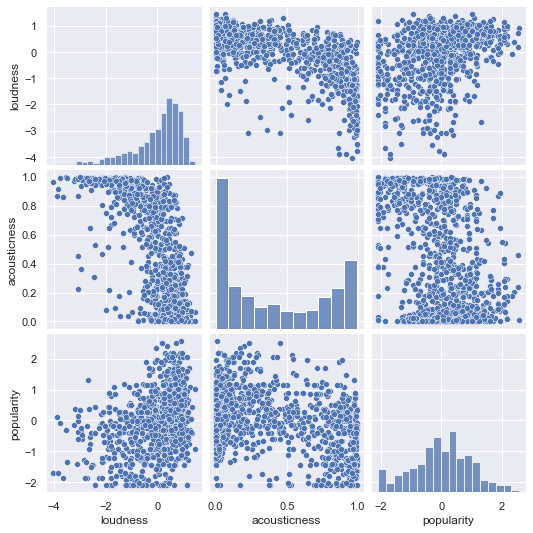

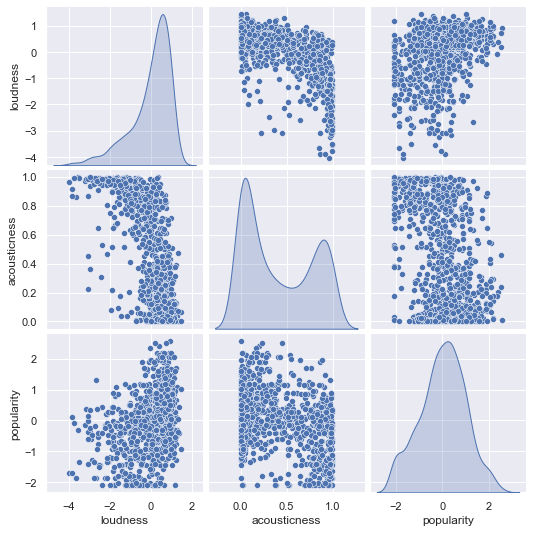

In [252]:
sample = df.sample(1000)
g = sns.pairplot(sample[["loudness", "acousticness", "popularity"]])
sns.pairplot(sample[["loudness", "acousticness", "popularity"]],diag_kind="kde")

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [193]:
# separate the data to training and testing
X_train, X_test, y_train,y_test=train_test_split(X,y,test_size=0.2)
# save as np.array
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train) 
y_test = np.array(y_test) 

#Split into train and test, and train multiple models by sampling the train set. Finally, just test once on the test set.

In [194]:
# create a linear regression object
model_regression = linear_model.LinearRegression()

# create a random forest regression object
model_random_forest = RandomForestRegressor()

# create a random forest regression object
model_decision_tree = DecisionTreeRegressor()

In [ ]:
# Split into train and test, and train multiple models by sampling the train set. Finally, just test once on the test set.
# KFold with 5 splits 
folds = KFold(n_splits = 10, shuffle = True)
hyper_params = [{'n_features_to_select': list(range(0, 18))}] # specify range of hyperparameters
model_regression.fit(X_train,y_train)
rfe = RFE(model_regression) 
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)    

# fit the model
model_cv.fit(X_train, y_train)
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results 
y_pred_reg = model_cv.predict(X_test)
#model_regression.coef
mse1 = mean_squared_error(y_test,y_pred_reg)
# we want smaller rmse
rmse1 = np.sqrt(mse1)

In [ ]:
# The models
model_regression.fit(X_train,y_train)
model_random_forest.fit(X_train,y_train)
model_decision_tree.fit(X_train,y_train)

In [ ]:
# create a random forest regression object
model_random_forest = RandomForestRegressor(n_estimators = 200)

model_random_forest.fit(X_train,y_train)
# estimate the R² score on train data
print("Train data - the R^2 is",model_random_forest.score(X_train,y_train))
# estimate the R² score on test data
print("Test data - the R^2 is",model_random_forest.score(X_test,y_test))

In [ ]:
hyper_params = [{'n_features_to_select': list(range(0, 18))}] # specify range of hyperparameters
model_regression.fit(X_train,y_train)
rfe = RFE(model_regression) 
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)


cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results 

In [ ]:
 y_pred_decision_tree= model_cv.predict(X_test)
#model_regression.coef
mse1 = mean_squared_error(y_test,y_pred_decision_tree)
# we want smaller rmse
rmse1 = np.sqrt(mse1)
print(rmse1)

In [ ]:
# estimate the R² score on train data
print("Train data - the R^2 is",model_regression.score(X_train,y_train))
# estimate the R² score on test data
print("Test data - the R^2 is",model_regression.score(X_test,y_test))

In [ ]:
# estimate the R² score on train data
print("Train data - the R^2 is",model_random_forest.score(X_train,y_train))
# estimate the R² score on test data
print("Test data - the R^2 is",model_random_forest.score(X_test,y_test))

In [ ]:
# estimate the R² score on train data
print("Train data - the R^2 is",model_decision_tree.score(X_train,y_train))
# estimate the R² score on test data
print("Test data - the R^2 is",model_decision_tree.score(X_test,y_test))

In [ ]:
y_pred_reg = model_regression.predict(X_test)
y_pred_random_forset = model_random_forest.predict(X_test)
y_pred_decision_tree = model_decision_tree.predict(X_test)

sns.regplot(y_test,y_pred_reg)
from sklearn.metrics import mean_squared_error

#model_regression.coef
mse1 = mean_squared_error(y_test,y_pred_reg)
# we want smaller rmse
rmse1 = np.sqrt(mse1)
print(rmse1)

mse2 = mean_squared_error(y_test,y_pred_random_forset)
# we want smaller rmse
rmse2 = np.sqrt(mse2)
print(rmse2)

mse3 = mean_squared_error(y_test,y_pred_decision_tree)
# we want smaller rmse
rmse3 = np.sqrt(mse3)
print(rmse3)

In [ ]:
import matplotlib.pyplot as plt
test_samples = 10
regression = []
random_forest = []
decision_tree = []
ground_truth = []
for i in range(test_samples): 
    regression.append(model_regression.predict([X_test[i]])) 
    random_forest.append(model_random_forest.predict([X_test[i]]))
    decision_tree.append(model_decision_tree.predict([X_test[i]]))
    ground_truth.append(y_test[i])

plt.plot(range(len(regression)), regression, label='Linear Regression')
plt.plot(range(len(random_forest)), random_forest, label='Random Forest')
plt.plot(range(len(decision_tree)), decision_tree, label='Decision Tree')
plt.plot(range(len(ground_truth)), ground_truth, label='Ground Truth')
plt.xlim([0, test_samples])
plt.ylim([0, 100])
plt.xlabel('songs')
plt.ylabel('popularity')
plt.legend()
plt.show()

In [ ]:
# Variables normalization
acousticness = [0,1]
danceability = [0,1]
duration_s = [0,600]
energy = [0,1]
instrumentalness = [0,1]
liveness = [0,1]
loudness= [ -60,0]
speechiness = [0,1]
tempo = [0,250]
valence = [0,1]
mode = [0,1]
features_range = {"acousticness":[0,1],"danceability" : [0,1],"duration_s":[0,600],"energy":[0,1],"instrumentalness":[0,1],"liveness":[0,1],"loudness": [-60,0],"speechiness" : [0,1],"tempo" : [0,250],"valence" : [0,1],"mode" : [0,1]}


In [ ]:
regression = [50]
random_forest = [50]
decision_tree = [50]
features = X.shape[1]
widgets_box = []
headers = X.columns
temp_sample =X.iloc[5]

#features_range["acousticness"][0]
for feature in range(features):
    
    temp_widget = widgets.FloatSlider(
    value=temp_sample[feature],
    min=features_range[headers[feature]][0],
    max=features_range[headers[feature]][1],
    step=0.1,
    description=headers[feature],
    disabled=False,
    continuous_update=False,
    orientation='vertical',
    readout=True,
    readout_format='.1f',
    )
    widgets_box.append(temp_widget)


box = Box(children=widgets_box)
box 

In [ ]:
for feature in range(features): 
    temp_sample[feature] = widgets_box[feature].value


In [ ]:

regression.append(model_regression.predict([temp_sample])) 
random_forest.append(model_random_forest.predict([temp_sample]))
decision_tree.append(model_decision_tree.predict([temp_sample]))

# Plot a simple line chart
plt.plot(range(len(regression)), regression, label='Linear Regression')
plt.plot(range(len(random_forest)), random_forest, label='Random Forest')
plt.plot(range(len(decision_tree)), decision_tree, label='Decision Tree')
plt.xlim([0, len(regression)])
plt.ylim([0, 100])
plt.legend()
plt.show()

In [247]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print(torch.cuda.get_device_name(device=device)) # check what kind of cpu/gpu we have

In [249]:
# deep learning - create tensors
X_tensor = torch.tensor(X.values,dtype=torch.float, device = device)
y_tensor = torch.tensor(y.values,dtype=torch.float)

# build Neural Networks - 18 input features, 100 hiden layers
model = nn.Sequential(nn.Linear(X.shape[1],100),nn.ReLU(),nn.Linear(100,1))
model.to(device)

Sequential(
  (0): Linear(in_features=21, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)

In [248]:
X.shape[1]

21

In [251]:
# Train the Nueral Network
# Mean square error
criterion = torch.nn.MSELoss() 
# Training the model using SGD approach 
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)

#Training
n_iters = X.shape[1]
for epoch in range(n_iters):
    total_loss = 0
    for i in range(len(X_tensor)):
        y_pred = model(X_tensor[i]) # single forward pass
        loss = criterion(y_pred,y_tensor[i]) # estimating the model's prediction
        total_loss += loss.item() 

        #weights update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Total loss: ", total_loss)



Total loss:  nan
Total loss:  nan
Total loss:  nan
Total loss:  nan
Total loss:  nan
Total loss:  nan


KeyboardInterrupt: 

In [ ]:
graphPreditions(model,y_tensor,y_pred,0,300)

In [262]:

def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu,input_shape=[X.shape[1]]),
        layers.Dense(64, activation = tf.nn.relu),
        layers.Dense(1)

    ])

    optimizer = tf.keras.optimizers.RMSprop(.001)

    model.compile(loss="mse",optimizer=optimizer,metrics=['mae','mse']) # examine our model

    return model


In [263]:
model = build_model()
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                1408      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________


In [278]:
# train the model
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        if epoch % 100==0: print("")
        print('.',end="")

EPOCHS = 100
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = model.fit(
    X,y, epochs = EPOCHS,validation_split = 0.2, verbose = 0,callbacks = [PrintDot()])



....................................................................................................

In [280]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,0.381741,0.471790,0.381741,0.590950,0.626141,0.590950,95
96,0.381474,0.471600,0.381474,0.573540,0.620687,0.573540,96
97,0.381509,0.471779,0.381509,0.556250,0.608771,0.556250,97
98,0.382115,0.472081,0.382115,0.531554,0.595131,0.531554,98
99,0.381294,0.471810,0.381294,0.592222,0.629787,0.592222,99


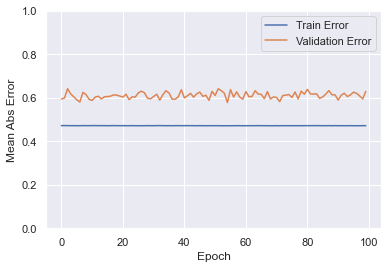

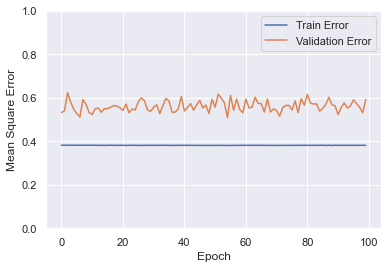

In [284]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'],label='Train Error')
    plt.plot(hist['epoch'],hist['val_mae'],label='Validation Error')
    plt.legend()
    plt.ylim([0,1])

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],label='Validation Error')
    plt.legend()
    plt.ylim([0,1])

plot_history(history)   

0.4138680398464203
1105/1105 [==============================] - 1s 1ms/step


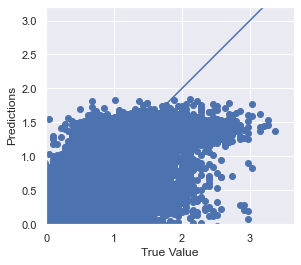

In [283]:
loss, mae, mse = model.evaluate(X_test,y_test,verbose=0)
print(mse)

test_predictions = model.predict(X_test).flatten()
plt.scatter(y_test, test_predictions)
plt.xlabel("True Value")
plt.ylabel("Predictions")
plt.axis('equal')
plt.axis('Square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])


